In [1]:
#Standard packages
import networkx as nx
import networkx.convert_matrix as nxmat
import numpy as np
import random
import scipy as sp
import math
import importlib


# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

import GraphRicciCurvature

#Load Girvan-Newman modularity 
from networkx.algorithms.community import greedy_modularity_communities

#High res figs for output

#plt.rcParams['figure.dpi'] = 600
#plt.rcParams['savefig.dpi'] = 600


# Experiment 1 - Random graphs with community structure to test modularity vs Ollivier Ricci Flow

We programme a function which generates random graphs with clear, artificial "ground-truth" binary community structure. Then we apply ORF, greedy Modularity and Louvain. We calculate their accuracy in each case with respect to the 'ground-truth' partition. We do this over 3 graphs which have community structur as follows: G_1  = stronger, G_2 = medium, G_3 = weaker. 

Thank you for reading.

## First a bunch of stuff we need from Saibalmar's Ollivier Ricci Curvature Package with a few edits

https://github.com/saibalmars/GraphRicciCurvature

In [2]:
def show_results_G_1(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_1 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color= "C4")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (G_1)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color= "C4")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (G_1)")

    plt.tight_layout()

In [3]:
def show_results_G_2(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_2 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color= "C6")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (G_2)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color= "C6")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (G_2)")

    plt.tight_layout()

In [4]:
def show_results_G_3(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_3 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color= "C9")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (G_3)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color= "C9")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (G_3)")

    plt.tight_layout()

In [5]:
# Minor adjustment here to agree with our graph generating function

def draw_graph(G, clustering_label="partition"):
    """
    A helper function to draw a nx graph with community.
    """
    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    node_color = le.fit_transform(list(complex_list.values()))

    nx.draw_spring(G, nodelist=G.nodes(),
                   node_color=node_color,
                   cmap=plt.cm.rainbow,
                   alpha=0.8)

In [6]:
def ARI(G, clustering, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)



def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0):
    """A simple surgery function that remove the edges with weight above a threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: str
        The edge weight used as Ricci flow metric. (Default value = "weight")
    cut: float
        Manually assigned cutoff point.

    Returns
    -------
    G : NetworkX graph
        A graph after surgery.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc = list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.quality.modularity(G, cc))
    print("* ARI now: %f " % ARI(G, cc))
    print("*********************************************")

    return G


In [7]:
# Minor changes to remove ARI from plot

def check_accuracy(G_origin, weight="weight", clustering_label="value", plot_cut=True):
    """To check the clustering quality while cut the edges with weight using different threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: float
        The edge weight used as Ricci flow metric. (Default value = "weight")
    clustering_label : str
        Node attribute name for ground truth.
    plot_cut: bool
        To plot the good guessed cut or not.

    """
    G = G_origin.copy()
    modularity, ari = [], []
    maxw = max(nx.get_edge_attributes(G, weight).values())
    cutoff_range = np.arange(maxw, 1, -0.025)

    for cutoff in cutoff_range:
        edge_trim_list = []
        for n1, n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                edge_trim_list.append((n1, n2))
        G.remove_edges_from(edge_trim_list)

        # Get connected component after cut as clustering
        clustering = {c: idx for idx, comp in enumerate(nx.connected_components(G)) for c in comp}

        # Compute modularity and ari
        modularity.append(community_louvain.modularity(clustering, G, weight))
        ari.append(ARI(G, clustering, clustering_label=clustering_label))

    plt.xlim(maxw, 0)
    plt.xlabel("Edge weight cutoff")
    plt.plot(cutoff_range, modularity, alpha=0.8)
    #plt.plot(cutoff_range, ari, alpha=0.8)

    if plot_cut:
        good_cut = -1
        mod_last = modularity[-1]
        drop_threshold = 0.01  # at least drop this much to considered as a drop for good_cut
    
        # check drop from 1 -> maxw
        for i in range(len(modularity) - 1, 0, -1):
            mod_now = modularity[i]
            if mod_last > mod_now > 1e-4 and abs(mod_last - mod_now) / mod_last > drop_threshold:
                if good_cut != -1:
                    print("Other cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        cutoff_range[i + 1], mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
                else:
                    good_cut = cutoff_range[i + 1]
                    print("*Good Cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        good_cut, mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
            mod_last = mod_now

        plt.axvline(x=good_cut, color="red")
        plt.legend(['Modularity', 'Good cut'])
    else:
        plt.legend(['Modularity'])

## Now we set up some Wrangling Tools

In [8]:
def frozenset_to_list(myfrozenset):
    mylist = [list(x) for x in myfrozenset]
    return mylist


def list_to_set(mylist):
    myset = set(tuple(x) for x in mylist)
    return myset


def select_key_0(mydict):
    return [key 
                for key, value in mydict.items()
                if value < 1]

def select_key_1(mydict):
    return [key 
                for key, value in mydict.items()
                if value > 0]

def keys_to_list(key_0,key_1):
    return [key_0,key_1]

def dict_to_list(mydict):
    mylist = [select_key_0(mydict), select_key_1(mydict)]
    return mylist


def method_accuracy(G_partition_list, G_method_list):
    compare_list = []
    for i in range(len(G_partition_list)):
        for j in range(len(G_method_list)):
            compare_list.append(sum(x in G_partition_list[i] for x in G_method_list[j]))

    max_compare_list = max(compare_list)
    compare_list.remove(max_compare_list) 
    second_max_compare_list = max(compare_list)

    return (second_max_compare_list + max_compare_list)/20




## Now we can generate some graphs 

In [9]:
# Random graph model with 2 communities

def make_graph(interintra=0.01, N=20, L=60, seed=0):
    
    nodes = [x for x in range(N)]
    rng = np.random.default_rng(seed)
    communities = rng.integers(0, 2, N, dtype=int)
    partition = {node: community for node, community in zip(nodes, communities)}
                 
    
    probs = np.array([[1 if i == j else interintra for j in communities] for i in communities], dtype=float)        
    A = np.zeros([N, N])
    lower = np.arange(N)
    mask = lower[:, None] > lower
    probs = probs[mask]
    probs = probs/probs.sum()
    indices = [(i, j) for i in range(N) for j in range(i)]
    
    edges = rng.choice(indices, size=L, p=probs, replace=False)
    for x in edges:
        A[x[0], x[1]] = 1
    A = A + A.T 
    G = nxmat.from_numpy_array(A, create_using=nx.Graph)
    
    nx.set_node_attributes(G, partition, name="partition")
    
    return G, partition

In [10]:
# Manipulating nx spring_layout function for better figures

def spring(G, partition, figsize=(10, 10)):
    
    plt.subplots(figsize=figsize)
    pos = nx.drawing.layout.spring_layout(G, iterations=50, seed=0)
    cols = ['purple' if x == 1 else 'green' for x in partition.values()]

    nx.draw(G, pos, node_color=cols, edge_color='grey', alpha=0.85)

In [11]:
# Make 3 graphs
G_1, partition_1 = make_graph(interintra=0.01, seed=1)
G_2, partition_2 = make_graph(interintra=0.05, seed=2)
G_3, partition_3 = make_graph(interintra=0.1, seed=3)

In [12]:
G_1_partition_list = dict_to_list(partition_1)
G_2_partition_list = dict_to_list(partition_2)
G_3_partition_list = dict_to_list(partition_3)

### Raw Graph Plots

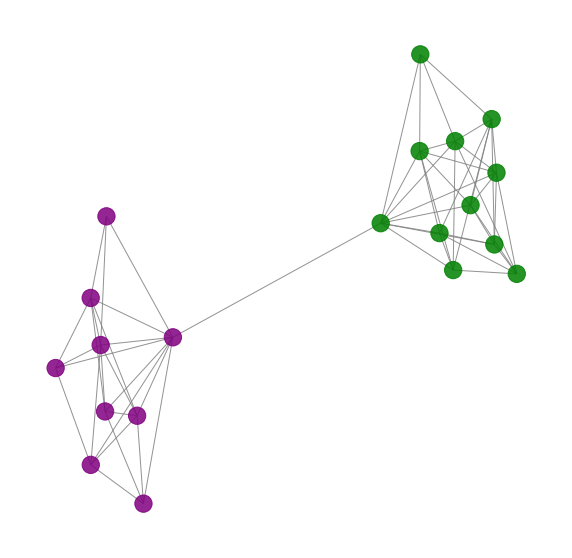

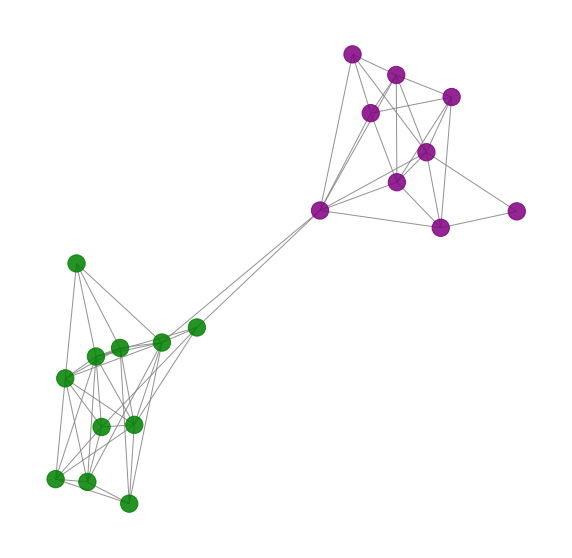

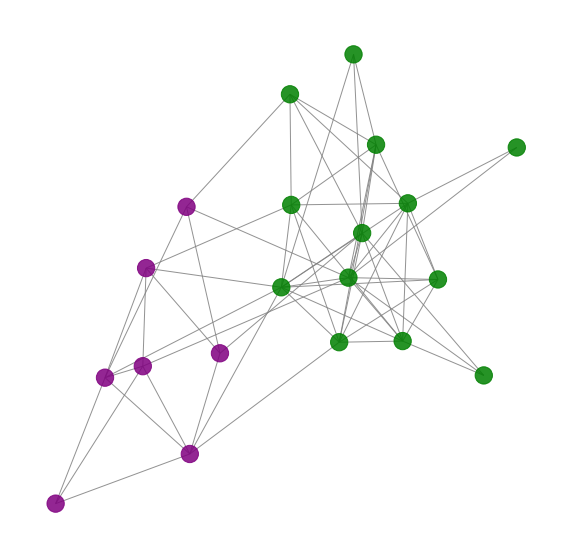

In [13]:
# Draw graphs
spring(G_1, partition_1, figsize=(10, 10))
spring(G_2, partition_2, figsize=(10, 10))
spring(G_3, partition_3, figsize=(10, 10))

## Now we need to do ORF on the 3 graphs with Lin-Yau's probability distribution and alpha = 0.5

### First we look at G_1 with 1 iteration of RF (just the initial Ricci curvature) vs 50 iterations

TRACE:Number of nodes: 20
TRACE:Number of edges: 60
TRACE:Start to compute all pair shortest path.
TRACE:0.002038 secs for all pair by NetworKit.
INFO:0.066794 secs for Ricci curvature computation.


G_1 Graph, first 5 edges: 
Ricci curvature of edge (0,4) is 0.285714
Ricci curvature of edge (0,8) is 0.285714
Ricci curvature of edge (0,11) is 0.214286
Ricci curvature of edge (0,14) is 0.357143
Ricci curvature of edge (0,15) is 0.285714


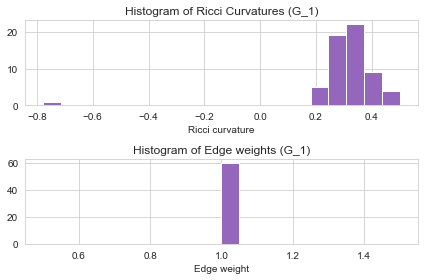

In [14]:
#Initial Ricci Curvature
orc_G_1 = OllivierRicci(G_1, alpha=0.5, verbose="TRACE")
orc_G_1.compute_ricci_curvature()
G_1_orc = orc_G_1.G.copy() 
show_results_G_1(G_1_orc)


G_1 Graph, first 5 edges: 
Ricci curvature of edge (0,4) is 0.013060
Ricci curvature of edge (0,8) is 0.013058
Ricci curvature of edge (0,11) is 0.013058
Ricci curvature of edge (0,14) is 0.013057
Ricci curvature of edge (0,15) is 0.013060


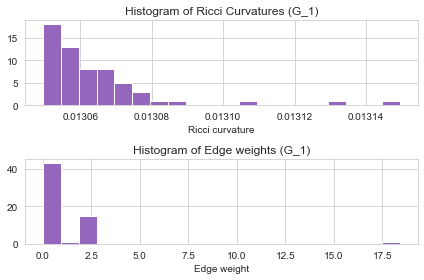

In [15]:
#Now 50 iterations

orf_G_1 = OllivierRicci(G_1, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_1.set_verbose("ERROR") # mute logs
orf_G_1.compute_ricci_flow(iterations=50)

G_1_rf = orf_G_1.G.copy()
show_results_G_1(G_1_rf)

### Now the same comparison for G_2

TRACE:Number of nodes: 20
TRACE:Number of edges: 60
TRACE:Start to compute all pair shortest path.
TRACE:0.000334 secs for all pair by NetworKit.
INFO:0.072455 secs for Ricci curvature computation.


G_2 Graph, first 5 edges: 
Ricci curvature of edge (0,10) is 0.416667
Ricci curvature of edge (0,12) is 0.400000
Ricci curvature of edge (0,14) is 0.250000
Ricci curvature of edge (0,16) is 0.250000
Ricci curvature of edge (1,2) is 0.416667


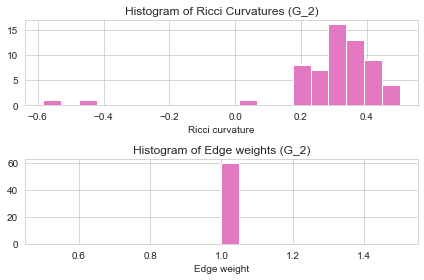

In [16]:
#Initial Ricci Curvature
orc_G_2 = OllivierRicci(G_2, alpha=0.5, verbose="TRACE")
orc_G_2.compute_ricci_curvature()
G_2_orc = orc_G_2.G.copy() 
show_results_G_2(G_2_orc)

G_2 Graph, first 5 edges: 
Ricci curvature of edge (0,10) is 0.023306
Ricci curvature of edge (0,12) is 0.023311
Ricci curvature of edge (0,14) is 0.023324
Ricci curvature of edge (0,16) is 0.023295
Ricci curvature of edge (1,2) is 0.023310


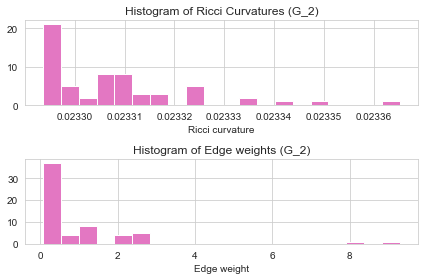

In [17]:
#Now 50 iterations

orf_G_2 = OllivierRicci(G_2, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_2.set_verbose("ERROR") # mute logs
orf_G_2.compute_ricci_flow(iterations=50)

G_2_rf = orf_G_2.G.copy()
show_results_G_2(G_2_rf)

### Finally the same treatment for G_3

TRACE:Number of nodes: 20
TRACE:Number of edges: 60
TRACE:Start to compute all pair shortest path.
TRACE:0.000336 secs for all pair by NetworKit.
INFO:0.058594 secs for Ricci curvature computation.


G_3 Graph, first 5 edges: 
Ricci curvature of edge (0,2) is -0.041667
Ricci curvature of edge (0,5) is 0.125000
Ricci curvature of edge (0,7) is 0.125000
Ricci curvature of edge (0,16) is 0.125000
Ricci curvature of edge (1,9) is 0.225000


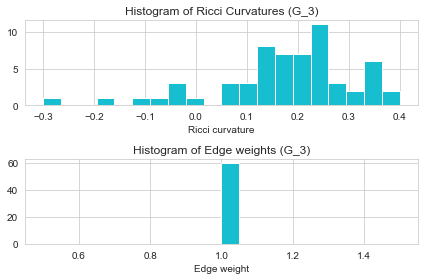

In [18]:
#Initial Ricci Curvature
orc_G_3 = OllivierRicci(G_3, alpha=0.5, verbose="TRACE")
orc_G_3.compute_ricci_curvature()
G_3_orc = orc_G_3.G.copy() 
show_results_G_3(G_3_orc)

G_3 Graph, first 5 edges: 
Ricci curvature of edge (0,2) is 0.114296
Ricci curvature of edge (0,5) is 0.114304
Ricci curvature of edge (0,7) is 0.114313
Ricci curvature of edge (0,16) is 0.114291
Ricci curvature of edge (1,9) is 0.114309


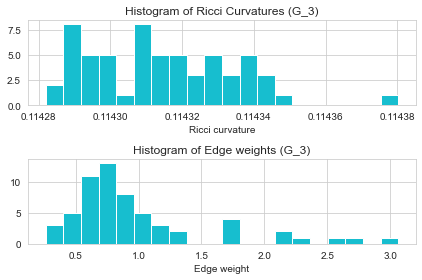

In [19]:
#Now 50 iterations

orf_G_3 = OllivierRicci(G_3, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_3.set_verbose("ERROR") # mute logs
orf_G_3.compute_ricci_flow(iterations=50)

G_3_rf = orf_G_3.G.copy()
show_results_G_3(G_3_rf)

### Now we do surgery on G_1

*Good Cut:1.984887, diff:0.033192, mod_now:0.466774, mod_last:0.499967, ari:1.000000


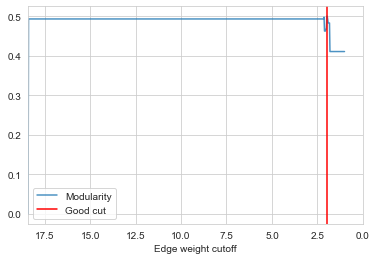

In [20]:
check_accuracy(G_1_rf,clustering_label="partition",plot_cut=True)


In [21]:
G_1_surg = my_surgery(G_1_rf, cut=1.984887)

*************** Surgery time ****************
* Cut 13 edges.
* Number of nodes now: 20
* Number of edges now: 47
* Modularity now: 0.499967 
* ARI now: 1.000000 
*********************************************


### Now we do surgery on G_2

*Good Cut:1.075647, diff:0.081070, mod_now:0.494710, mod_last:0.575780, ari:0.722628
Other cut:1.100647, diff:0.009959, mod_now:0.484751, mod_last:0.494710, ari:0.915339
Other cut:1.200647, diff:0.013683, mod_now:0.471068, mod_last:0.484751, ari:0.915339
Other cut:1.250647, diff:0.015848, mod_now:0.455220, mod_last:0.471068, ari:0.915339
Other cut:1.275647, diff:0.016647, mod_now:0.438573, mod_last:0.455220, ari:0.915339
Other cut:1.325647, diff:0.033428, mod_now:0.405145, mod_last:0.438573, ari:0.915339
Other cut:2.100647, diff:0.024592, mod_now:0.380552, mod_last:0.405145, ari:0.915339
Other cut:2.150647, diff:0.022938, mod_now:0.357614, mod_last:0.380552, ari:0.915339
Other cut:2.175647, diff:0.020937, mod_now:0.336677, mod_last:0.357614, ari:0.915339


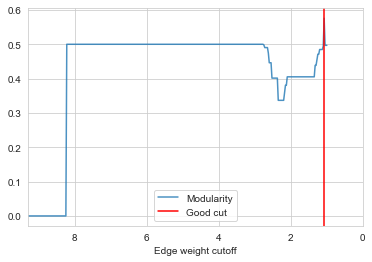

In [22]:
check_accuracy(G_2_rf,clustering_label="partition",plot_cut=True)


In [23]:
G_2_surg = my_surgery(G_2_rf, cut=1.075647)

*************** Surgery time ****************
* Cut 18 edges.
* Number of nodes now: 20
* Number of edges now: 42
* Modularity now: 0.575780 
* ARI now: 1.000000 
*********************************************


### Now we do surgery on G_3

*Good Cut:1.086916, diff:0.008377, mod_now:0.327818, mod_last:0.336195, ari:1.000000
Other cut:1.136916, diff:0.008363, mod_now:0.319455, mod_last:0.327818, ari:1.000000
Other cut:1.186916, diff:0.008414, mod_now:0.311042, mod_last:0.319455, ari:1.000000


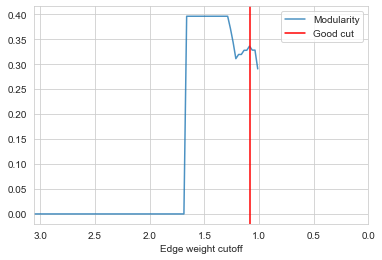

In [24]:
check_accuracy(G_3_rf,clustering_label="partition",plot_cut=True)


In [25]:
G_3_surg = my_surgery(G_3_rf, cut=1.086916)

*************** Surgery time ****************
* Cut 16 edges.
* Number of nodes now: 20
* Number of edges now: 44
* Modularity now: 0.336195 
* ARI now: 1.000000 
*********************************************


### Now we look at all our surgeries

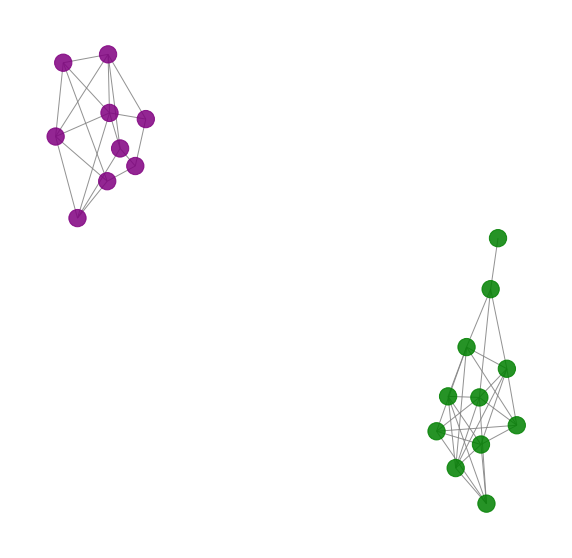

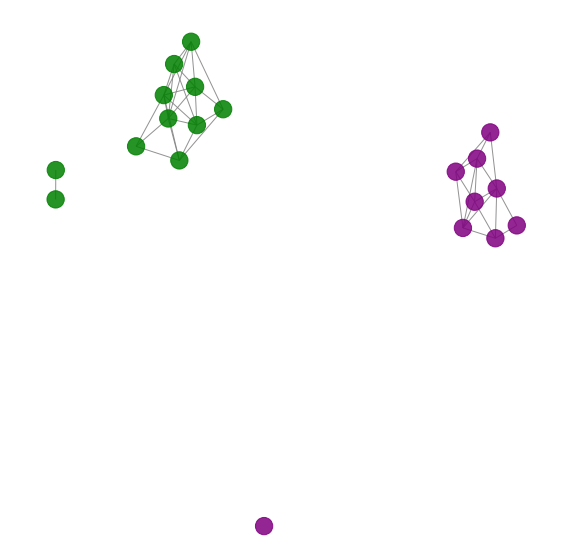

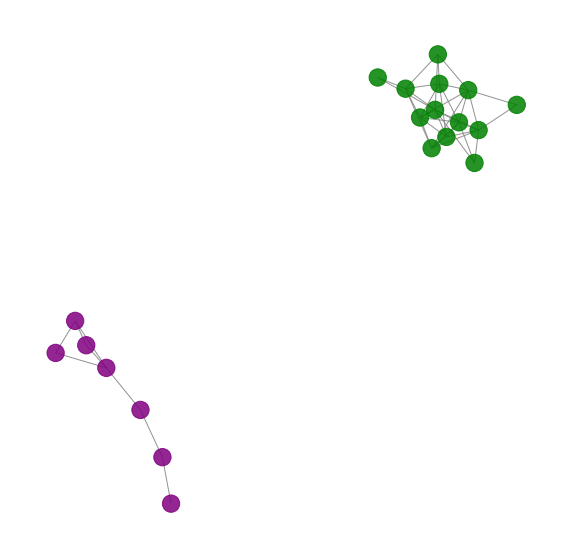

In [26]:
spring(G_1_surg, partition_1)
spring(G_2_surg, partition_2)
spring(G_3_surg, partition_3)

## Now we want to calculate the accuracy of each method on all 3 graphs

### ORF Accuracy

In [27]:
#Networkx-wrangling to get communities after surgery into set. Didn't make a function bc of time so not scalable

S_1 = [G_1_surg.subgraph(c).copy() for c in nx.connected_components(G_1_surg)]
G_1_surg_list = [list(S_1[0].nodes), list(S_1[1].nodes)]
G_1_surg_list = [list(x) for x in G_1_surg_list]

S_2 = [G_2_surg.subgraph(c).copy() for c in nx.connected_components(G_2_surg)]
G_2_surg_list = [list(S_2[0].nodes), list(S_2[1].nodes), list(S_2[2].nodes), list(S_2[3].nodes)]
G_2_surg_list = [list(x) for x in G_2_surg_list]

S_3 = [G_3_surg.subgraph(c).copy() for c in nx.connected_components(G_3_surg)]
G_3_surg_list = [list(S_3[0].nodes), list(S_3[1].nodes)]
G_3_surg_list = [list(x) for x in G_3_surg_list]

print("G_1 ORF accuracy = " , method_accuracy(G_1_partition_list, G_1_surg_list))
print("G_2 ORF accuracy = " , method_accuracy(G_2_partition_list, G_2_surg_list))
print("G_3 ORF accuracy = " , method_accuracy(G_3_partition_list, G_3_surg_list))

G_1 ORF accuracy =  1.0
G_2 ORF accuracy =  0.85
G_3 ORF accuracy =  1.0


### Greedy Accuracy

In [28]:
G_1_greedy_list = frozenset_to_list(greedy_modularity_communities(G_1))
G_2_greedy_list = frozenset_to_list(greedy_modularity_communities(G_2))
G_3_greedy_list = frozenset_to_list(greedy_modularity_communities(G_3))

print("G_1 greedy accuracy = " , method_accuracy(G_1_partition_list, G_1_greedy_list))
print("G_2 greedy accuracy = " , method_accuracy(G_2_partition_list, G_2_greedy_list))
print("G_3 greedy accuracy = " , method_accuracy(G_3_partition_list, G_3_greedy_list))

G_1 greedy accuracy =  1.0
G_2 greedy accuracy =  1.0
G_3 greedy accuracy =  0.8


### Louvain Accuracy

In [29]:
G_1_louvain_list = dict_to_list(community_louvain.best_partition(G_1))
G_2_louvain_list = dict_to_list(community_louvain.best_partition(G_2))
G_3_louvain_list = dict_to_list(community_louvain.best_partition(G_3))

print("G_1 Louvain accuracy = " , method_accuracy(G_1_partition_list, G_1_louvain_list))
print("G_2 Louvain accuracy = " , method_accuracy(G_2_partition_list, G_2_louvain_list))
print("G_3 Louvain accuracy = " , method_accuracy(G_3_partition_list, G_3_louvain_list))

G_1 Louvain accuracy =  1.0
G_2 Louvain accuracy =  1.0
G_3 Louvain accuracy =  1.0


# Experiment 2 
## Ring of cliques to test modularity vs ORF

We generate rings of cliques which are susceptible to the resolution limit in modularity community detection. Then we test whether these communities (the cliques) are succsesfully detected by ORF

## Minor Edits to stuff from Saibalmar's Package again
Not the cleanest way to edit the histograms but works and was time pressured

In [30]:
def show_results_G_1(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_1 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color="C4")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures n=6, m=3")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color="C4")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights n=6, m=3")

    plt.tight_layout()

def show_results_G_2(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_2 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color="C6")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures n=20, m=6")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color="C6")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights n=20, m=6")

    plt.tight_layout()

def show_results_G_3(G, curvature="ricciCurvature"):

    # Print the first five results
    print("G_3 Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20, color="C4")
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures n=30, m=5")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20, color="C4")
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights n=30, m=5")

    plt.tight_layout()

## Now we can generate some rings of cliques

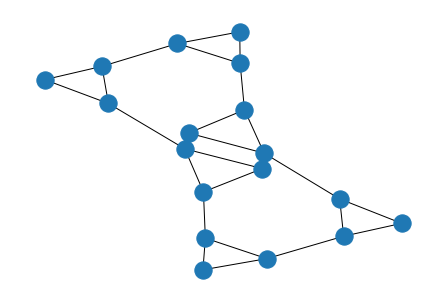

In [31]:
G_1 = nx.ring_of_cliques(6,3)
G_2 = nx.ring_of_cliques(20,6)
G_3 = nx.ring_of_cliques(30,5)
nx.draw(G_1)

## Now we run ORF for 50 iterations with Lin-Yau's probability distribution, alpha=0.5

### On 1st ring of cliques

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 18
TRACE:Number of edges: 24
TRACE:Start to compute all pair shortest path.
TRACE:0.000469 secs for all pair by NetworKit.
INFO:0.057009 secs for Ricci curvature computation.


G_1 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is 0.166667
Ricci curvature of edge (0,2) is 0.416667
Ricci curvature of edge (0,16) is -0.333333
Ricci curvature of edge (1,2) is 0.416667
Ricci curvature of edge (1,3) is -0.333333


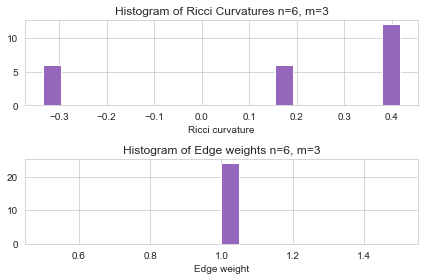

In [32]:
#Initial Ricci Curvature
orc_G_1 = OllivierRicci(G_1, alpha=0.5, verbose="TRACE")
orc_G_1.compute_ricci_curvature()
G_1_orc = orc_G_1.G.copy() 
show_results_G_1(G_1_orc)


INFO:Edge weight not detected in graph, use "weight" as default edge weight.


G_1 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.000019
Ricci curvature of edge (0,2) is 0.000019
Ricci curvature of edge (0,16) is 0.000006
Ricci curvature of edge (1,2) is 0.000019
Ricci curvature of edge (1,3) is 0.000006


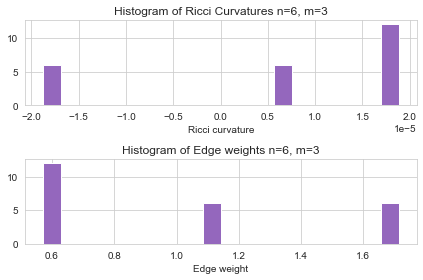

In [33]:
#Now 50 iterations

orf_G_1 = OllivierRicci(G_1, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_1.set_verbose("ERROR") # mute logs
orf_G_1.compute_ricci_flow(iterations=50)

G_1_rf = orf_G_1.G.copy()
show_results_G_1(G_1_rf)

*************** Surgery time ****************
* Cut 6 edges.
* Number of nodes now: 18
* Number of edges now: 18
* Modularity now: 0.833333 
* ARI now: 1.000000 
*********************************************
number of components 6
max component {0, 1, 2}
min component {0, 1, 2}


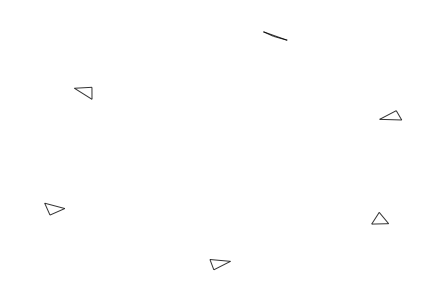

In [34]:
# We can clearly choose 1.5 as a good cut
G_1_surg = my_surgery(G_1_rf, cut=1.5)
# And we see it works
draw_graph(G_1_surg)
print("number of components" , nx.number_connected_components(G_1_surg))
print("max component" , max(nx.connected_components(G_1_surg), key=len))
print("min component" , min(nx.connected_components(G_1_surg), key=len))

### On 2nd ring of cliques

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 120
TRACE:Number of edges: 320
TRACE:Start to compute all pair shortest path.
TRACE:0.001198 secs for all pair by NetworKit.
INFO:0.068524 secs for Ricci curvature computation.


G_2 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is 0.333333
Ricci curvature of edge (0,2) is 0.433333
Ricci curvature of edge (0,3) is 0.433333
Ricci curvature of edge (0,4) is 0.433333
Ricci curvature of edge (0,5) is 0.433333


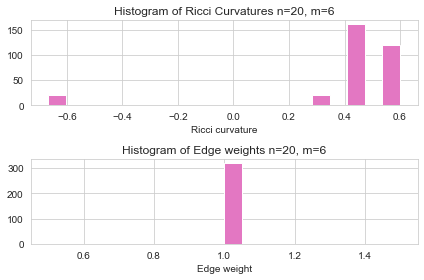

In [35]:
#Initial Ricci Curvature
orc_G_2 = OllivierRicci(G_2, alpha=0.5, verbose="TRACE")
orc_G_2.compute_ricci_curvature()
G_2_orc = orc_G_2.G.copy() 
show_results_G_2(G_2_orc)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.


G_2 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.000000
Ricci curvature of edge (0,2) is 0.000000
Ricci curvature of edge (0,3) is 0.000000
Ricci curvature of edge (0,4) is 0.000000
Ricci curvature of edge (0,5) is 0.000000


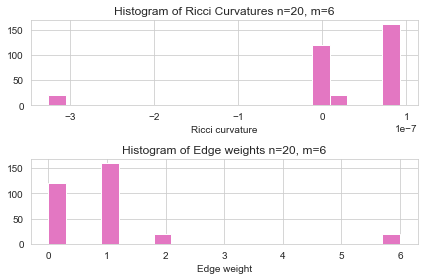

In [36]:
#Now 50 iterations

orf_G_2 = OllivierRicci(G_2, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_2.set_verbose("ERROR") # mute logs
orf_G_2.compute_ricci_flow(iterations=50)

G_2_rf = orf_G_2.G.copy()
show_results_G_2(G_2_rf)

*************** Surgery time ****************
* Cut 20 edges.
* Number of nodes now: 120
* Number of edges now: 300
* Modularity now: 0.950000 
* ARI now: 1.000000 
*********************************************
number of components 20
max component {0, 1, 2, 3, 4, 5}
min component {0, 1, 2, 3, 4, 5}


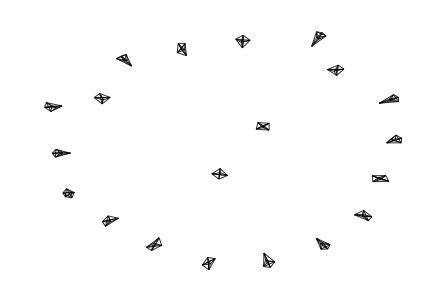

In [37]:
# We can clearly see 5 would work as a cut
G_2_surg = G_2_surg = my_surgery(G_2_rf, cut=5)
# Again we see it works
draw_graph(G_2_surg)
print("number of components" , nx.number_connected_components(G_2_surg))
print("max component" , max(nx.connected_components(G_2_surg), key=len))
print("min component" , min(nx.connected_components(G_2_surg), key=len))

## On 3rd ring of cliques

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 150
TRACE:Number of edges: 330
TRACE:Start to compute all pair shortest path.
TRACE:0.001770 secs for all pair by NetworKit.
INFO:0.074217 secs for Ricci curvature computation.


G_3 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is 0.300000
Ricci curvature of edge (0,2) is 0.425000
Ricci curvature of edge (0,3) is 0.425000
Ricci curvature of edge (0,4) is 0.425000
Ricci curvature of edge (0,146) is -0.600000


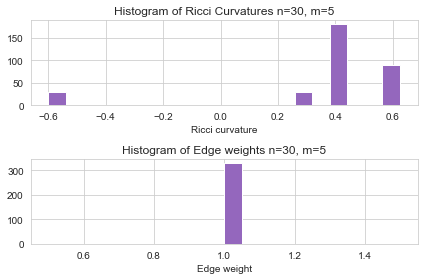

In [38]:
#Initial Ricci Curvature
orc_G_3 = OllivierRicci(G_3, alpha=0.5, verbose="TRACE")
orc_G_3.compute_ricci_curvature()
G_3_orc = orc_G_3.G.copy() 
show_results_G_3(G_3_orc)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.


G_3 Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.000000
Ricci curvature of edge (0,2) is 0.000000
Ricci curvature of edge (0,3) is 0.000000
Ricci curvature of edge (0,4) is 0.000000
Ricci curvature of edge (0,146) is 0.000000


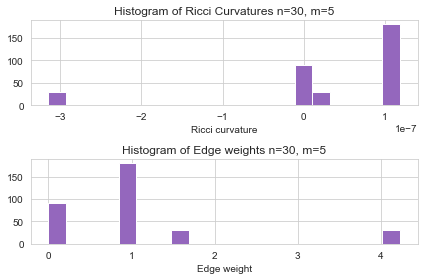

In [39]:
#Now 50 iterations

orf_G_3 = OllivierRicci(G_3, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
orf_G_3.set_verbose("ERROR") # mute logs
orf_G_3.compute_ricci_flow(iterations=50)

G_3_rf = orf_G_3.G.copy()
show_results_G_3(G_3_rf)

*************** Surgery time ****************
* Cut 30 edges.
* Number of nodes now: 150
* Number of edges now: 300
* Modularity now: 0.966667 
* ARI now: 1.000000 
*********************************************
number of components 30
max component {0, 1, 2, 3, 4}
min component {0, 1, 2, 3, 4}


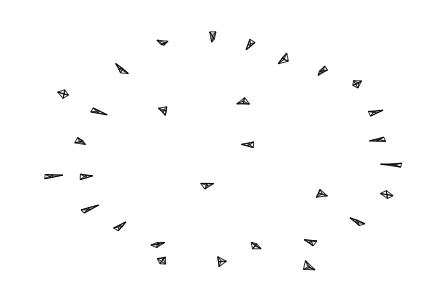

In [40]:
# We can clearly see 4 would work as a cut

G_3_surg = my_surgery(G_3_rf, cut=4)
draw_graph(G_3_surg)
nx.number_connected_components(G_3_surg)
print("number of components" , nx.number_connected_components(G_3_surg))
print("max component" , max(nx.connected_components(G_3_surg), key=len))
print("min component" , min(nx.connected_components(G_3_surg), key=len))

# Appendix: Making fig 6

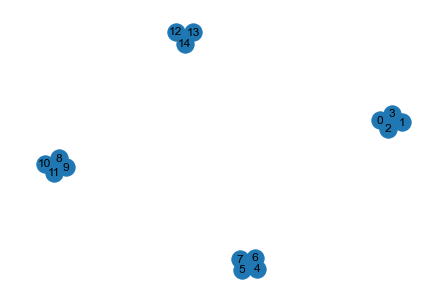

In [41]:
cycle = nx.cycle_graph(3)
clique = nx.complete_graph(4)
fig = nx.disjoint_union(clique,cycle)
fig = nx.disjoint_union(clique,fig)
fig = nx.disjoint_union(clique,fig)
nx.draw(fig,with_labels=True)

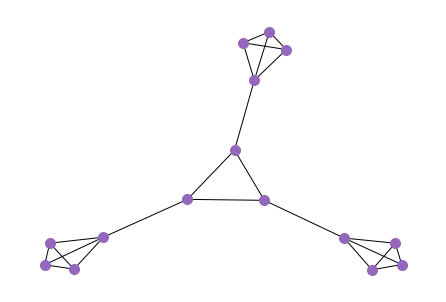

In [42]:
fig.add_edge(14,0)
fig.add_edge(13,5)
fig.add_edge(12,9)
nx.draw_spring(fig, node_size=100, node_color="C4")

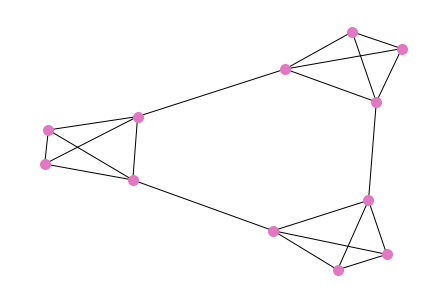

In [43]:
fig2 = nx.ring_of_cliques(3,4)
nx.draw_spring(fig2, node_size=100, node_color="C6")